# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import pathlib

# Define Hyperparameters

In [2]:
BATCH_SIZE = 32
EPOCHS = 50
LR = 0.01
IMAGE_SIZE = (224, 224)

sns.set()

# Prepare dataset

In [3]:
dataset_path = "./dataset"

In [4]:
CLASSES = os.listdir(DATA_DIR)
print(CLASSES)

['benign', 'normal', 'malignant']


We have tree classes we will be classifying

## Define data loading functions

In [5]:
# image paths
def get_image_lists():
    image_lists = tf.data.Dataset.list_files(str(pathlib.Path(DATA_DIR) /"*/*).png"))
    return image_lists

In [ ]:
image_lists = get_image_lists()
img_count = len(image_lists)
print("Number of images", img_count)
for i in image_lists.take(1):
    print(i)

In [7]:
split = tf.strings.split(i, "/")
split[-2].numpy()

b'malignant'

In [8]:
def decode_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, IMAGE_SIZE)
    if tf.shape(img)[2] == tf.convert_to_tensor(1):
        img = tf.image.grayscale_to_rgb(img)
    return img

In [9]:
def process_path(file_path):
    img = decode_image(file_path)
    label = tf.strings.split(file_path, "/")[-2] == CLASSES
    return img, tf.argmax(label)

In [10]:
data = image_lists.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for img, label in data.take(1):
    print(img)
    print(label.numpy())

# Split to train and test data

In [12]:
test_size = int(img_count * 0.2)
train_data = data.skip(test_size)
test_data = data.take(test_size)

In [13]:
def configure_for_training(data, is_train=False):
    data = data.cache()
    data = data.shuffle(buffer_size=300)
    data = data.batch(BATCH_SIZE)
    data = data.prefetch(buffer_size=tf.data.AUTOTUNE)
    return data
    
    

In [14]:
train_data = configure_for_training(train_data, is_train=True)
test_data = configure_for_training(test_data, is_train=True)

In [ ]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

## Plotting functions

In [16]:
def show_single(img, label):
    plt.imshow(img)
    plt.title(label)

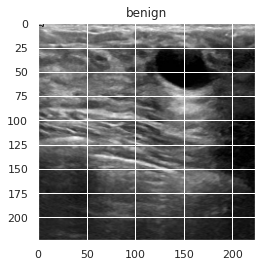

In [17]:
show_single(image_batch.numpy()[0], CLASSES[label_batch.numpy()[0]])

In [18]:
def show_batch(img_batch, label_batch):
    figure = plt.figure(figsize=(12, 10))
    n = 16
    sqrt = int(np.sqrt(n))
    for i in range(n):
        _ = plt.subplot(sqrt, sqrt, i + 1)
        show_single(img_batch[i], CLASSES[label_batch[i]])
        plt.axis('off')
    plt.show()

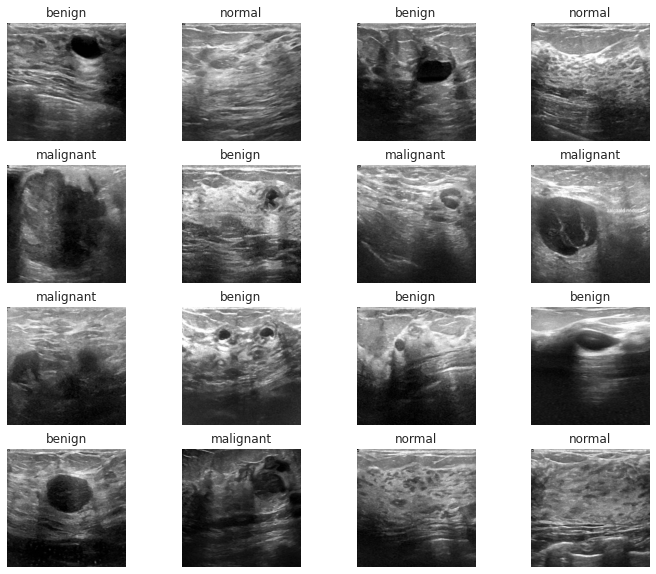

In [19]:
show_batch(image_batch, label_batch)

# Training 

## Build a simple classification model

In [20]:
def get_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR), 
        loss=tf.keras.losses.sparse_categorical_crossentropy, 
        metrics=[tf.keras.metrics.sparse_categorical_accuracy])
    return model

In [21]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1182819   
Total params: 1,183,715
Trainable params: 1,183,715
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data,
)

In [23]:
def visualize_loss(history):
    train_loss = history["loss"]
    val_loss = history["val_loss"]
    
    iterations = [i for i in range(EPOCHS)]
    
    plt.plot(iterations, train_loss, label="Training Loss", color="b")
    plt.plot(iterations, val_loss, label="Validation Loss", color="r")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
def visualize_acc(history):
    train_loss = history["sparse_categorical_accuracy"]
    val_loss = history["val_sparse_categorical_accuracy"]
    
    iterations = [i for i in range(EPOCHS)]
    
    
    plt.plot(iterations, train_loss, label="Training Accuracy", color="b")
    plt.plot(iterations, val_loss, label="Validation Accuracy", color="r")
    plt.title("Training and Validation accuracy")
    plt.legend()
    plt.show()
    
    

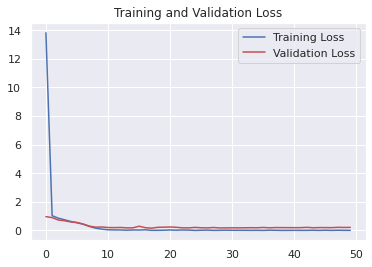

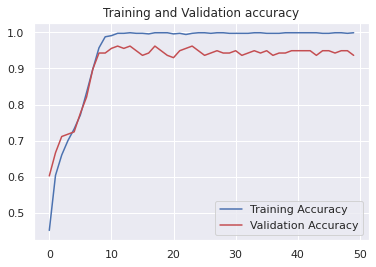

In [24]:
visualize_loss(history.history)
visualize_acc(history.history)

In [25]:
model.save("breast_lession_classification_model.h5")